In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [4]:
# print("\n" + "="*50)
print("LOADING DATA WITH TRAIN-TEST SPLIT")
print("="*50)

# Load dataset
df = pd.read_csv("cardio_train_clean_scaled.csv")
print(f" Original dataset shape: {df.shape}")

# Check the data first
print(" Data overview:")
print(f"   - Columns: {df.columns.tolist()}")
print(f"   - Target distribution: {df['cardio'].value_counts().to_dict()}")

# Check if data is already scaled (look for very small or standardized values)
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f" Data statistics (checking for scaling):")
print(df[numeric_cols].describe().round(3))

# SPLIT FIRST, then drop columns
X = df.drop(['cardio', 'weight', 'BMI_category_num'], axis=1)
y = df['cardio']

print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")

LOADING DATA WITH TRAIN-TEST SPLIT
 Original dataset shape: (69465, 14)
 Data overview:
   - Columns: ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years', 'BMI', 'BMI_category_num']
   - Target distribution: {0.0: 34791, 1.0: 34674}
 Data statistics (checking for scaling):
          gender     height     weight      ap_hi      ap_lo  cholesterol  \
count  69465.000  69465.000  69465.000  69465.000  69465.000    69465.000   
mean       0.350      0.429      0.214      0.372      0.462        0.184   
std        0.477      0.053      0.089      0.094      0.108        0.340   
min        0.000      0.000      0.000      0.000      0.000        0.000   
25%        0.000      0.393      0.156      0.333      0.444        0.000   
50%        0.000      0.433      0.200      0.333      0.444        0.000   
75%        1.000      0.467      0.262      0.444      0.556        0.500   
max        1.000      1.000      1.000   

In [5]:
# Train-Test Split with Feature Selection
print("\n" + "="*50)
print("TRAIN-TEST SPLIT WITH PROPER VALIDATION")
print("="*50)

# Split data FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Training set: {X_train.shape[0]:,} samples")
print(f" Testing set:  {X_test.shape[0]:,} samples")

# Feature selection on TRAINING DATA ONLY
k_features = min(15, X_train.shape[1])
print(f" Selecting top {k_features} features on training data...")

selector = SelectKBest(score_func=f_classif, k=k_features)
X_train_selected = selector.fit_transform(X_train, y_train)  # Fit only on training
X_test_selected = selector.transform(X_test)  # Transform test data

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print(f" Selected {len(selected_features)} features")

# Update with selected features
X_train = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_test = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

print(f" Final feature set: {X_train.shape[1]} features")


TRAIN-TEST SPLIT WITH PROPER VALIDATION
 Training set: 55,572 samples
 Testing set:  13,893 samples
 Selecting top 11 features on training data...
 Selected 11 features
 Final feature set: 11 features


In [6]:
# Scale Data
print("\n" + "="*50)
print("SCALING DATA (AFTER SPLIT)")
print("="*50)

# Scale features - Fit ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training
X_test_scaled = scaler.transform(X_test)        # Transform test only

print(" Checking if data was pre-scaled:")
print(f"   Training mean: {np.mean(X_train_scaled):.3f}")
print(f"   Training std:  {np.std(X_train_scaled):.3f}")
print(f"   Test mean:     {np.mean(X_test_scaled):.3f}")
print(f"   Test std:      {np.std(X_test_scaled):.3f}")

# If means are near 0 and std near 1, data was already scaled
if abs(np.mean(X_train_scaled)) < 0.1 and abs(np.std(X_train_scaled) - 1) < 0.1:
    print("  Data appears to be already scaled - using original values")
    X_train_scaled = X_train.values
    X_test_scaled = X_test.values

# Reshape for LSTM
timesteps = 1
n_features = X_train_scaled.shape[1]

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, n_features)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, n_features)

print(f" Data preparation completed!")
print(f" Training shape: {X_train_scaled.shape}")
print(f" LSTM shape: {X_train_lstm.shape}")


SCALING DATA (AFTER SPLIT)
 Checking if data was pre-scaled:
   Training mean: 0.000
   Training std:  1.000
   Test mean:     0.002
   Test std:      1.001
  Data appears to be already scaled - using original values
 Data preparation completed!
 Training shape: (55572, 11)
 LSTM shape: (55572, 1, 11)


In [7]:
# Train XGBoost with Cross-Validation
print("\n" + "="*50)
print("TRAINING XGBOOST WITH CROSS-VALIDATION")
print("="*50)

# XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,  # Reduced for faster training
    max_depth=4,       # Reduced to prevent overfitting
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Cross-validation to check real performance
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f" Cross-validation scores: {[f'{score:.3f}' for score in cv_scores]}")
print(f" CV Mean Accuracy: {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")

# Train on full training set
xgb_model.fit(X_train_scaled, y_train)

# Predictions
xgb_y_pred = xgb_model.predict(X_test_scaled)
xgb_y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_auc = roc_auc_score(y_test, xgb_y_pred_proba)

print(" XGBoost training completed!")
print(f" XGBoost Test Performance:")
print(f"   • Accuracy:  {xgb_accuracy * 100:.1f}%")
print(f"   • Precision: {xgb_precision * 100:.1f}%")
print(f"   • Recall:    {xgb_recall * 100:.1f}%")
print(f"   • F1-Score:  {xgb_f1 * 100:.1f}%")
print(f"   • AUC:       {xgb_auc:.3f}")

# Check if we have realistic accuracy
if xgb_accuracy > 0.95:
    print(" WARNING: Accuracy seems too high - possible data leakage!")


TRAINING XGBOOST WITH CROSS-VALIDATION
 Cross-validation scores: ['0.746', '0.734', '0.734', '0.737', '0.732']
 CV Mean Accuracy: 0.737 (+/- 0.005)
 XGBoost training completed!
 XGBoost Test Performance:
   • Accuracy:  73.5%
   • Precision: 75.7%
   • Recall:    69.3%
   • F1-Score:  72.3%
   • AUC:       0.801


In [8]:
# Train LightGBM
print("\n" + "="*50)
print("TRAINING LIGHTGBM")
print("="*50)

# LightGBM model
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

# Cross-validation
cv_scores = cross_val_score(lgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f" Cross-validation scores: {[f'{score:.3f}' for score in cv_scores]}")
print(f" CV Mean Accuracy: {np.mean(cv_scores):.3f}")

lgb_model.fit(X_train_scaled, y_train)

# Predictions
lgb_y_pred = lgb_model.predict(X_test_scaled)
lgb_y_pred_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
lgb_accuracy = accuracy_score(y_test, lgb_y_pred)
lgb_precision = precision_score(y_test, lgb_y_pred)
lgb_recall = recall_score(y_test, lgb_y_pred)
lgb_f1 = f1_score(y_test, lgb_y_pred)
lgb_auc = roc_auc_score(y_test, lgb_y_pred_proba)

print(" LightGBM training completed!")
print(f" LightGBM Test Performance:")
print(f"   • Accuracy:  {lgb_accuracy * 100:.1f}%")
print(f"   • Precision: {lgb_precision * 100:.1f}%")
print(f"   • Recall:    {lgb_recall * 100:.1f}%")
print(f"   • F1-Score:  {lgb_f1 * 100:.1f}%")
print(f"   • AUC:       {lgb_auc:.3f}")


TRAINING LIGHTGBM
 Cross-validation scores: ['0.744', '0.735', '0.735', '0.737', '0.732']
 CV Mean Accuracy: 0.737
 LightGBM training completed!
 LightGBM Test Performance:
   • Accuracy:  73.6%
   • Precision: 75.7%
   • Recall:    69.3%
   • F1-Score:  72.4%
   • AUC:       0.801


In [9]:
# Train LSTM with Validation
print("\n" + "="*50)
print("TRAINING LSTM WITH VALIDATION")
print("="*50)

# Build simpler LSTM to prevent overfitting
lstm_model = Sequential([
    LSTM(32, activation='tanh', return_sequences=True, input_shape=(timesteps, n_features)),
    Dropout(0.4),  # Increased dropout
    LSTM(16, activation='tanh'),
    Dropout(0.4),  # Increased dropout
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001
)

print("Training LSTM (this may take a few minutes)...")
history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=50,  # Reduced epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Predictions
lstm_y_pred_proba = lstm_model.predict(X_test_lstm).flatten()
lstm_y_pred = (lstm_y_pred_proba > 0.5).astype(int)

# Calculate metrics
lstm_accuracy = accuracy_score(y_test, lstm_y_pred)
lstm_precision = precision_score(y_test, lstm_y_pred)
lstm_recall = recall_score(y_test, lstm_y_pred)
lstm_f1 = f1_score(y_test, lstm_y_pred)
lstm_auc = roc_auc_score(y_test, lstm_y_pred_proba)

print(" LSTM training completed!")
print(f" LSTM Test Performance:")
print(f"   • Accuracy:  {lstm_accuracy * 100:.1f}%")
print(f"   • Precision: {lstm_precision * 100:.1f}%")
print(f"   • Recall:    {lstm_recall * 100:.1f}%")
print(f"   • F1-Score:  {lstm_f1 * 100:.1f}%")
print(f"   • AUC:       {lstm_auc:.3f}")


TRAINING LSTM WITH VALIDATION
Training LSTM (this may take a few minutes)...
Epoch 1/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.5978 - loss: 0.6612 - val_accuracy: 0.7130 - val_loss: 0.5719
Epoch 2/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7113 - loss: 0.5843 - val_accuracy: 0.7200 - val_loss: 0.5626
Epoch 3/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7165 - loss: 0.5781 - val_accuracy: 0.7211 - val_loss: 0.5591
Epoch 4/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7214 - loss: 0.5721 - val_accuracy: 0.7224 - val_loss: 0.5595
Epoch 5/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7258 - loss: 0.5722 - val_accuracy: 0.7247 - val_loss: 0.5580
Epoch 6/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7293 - loss: 0.5665 - val_accuracy: 0.7222 - val_loss: 0.5560
Epoch 7/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7266 - loss: 0.5712 - val_accuracy: 0.7229 - val_loss: 0.5552
Epoch 


ACTUAL VS PREDICTED VISUALIZATION


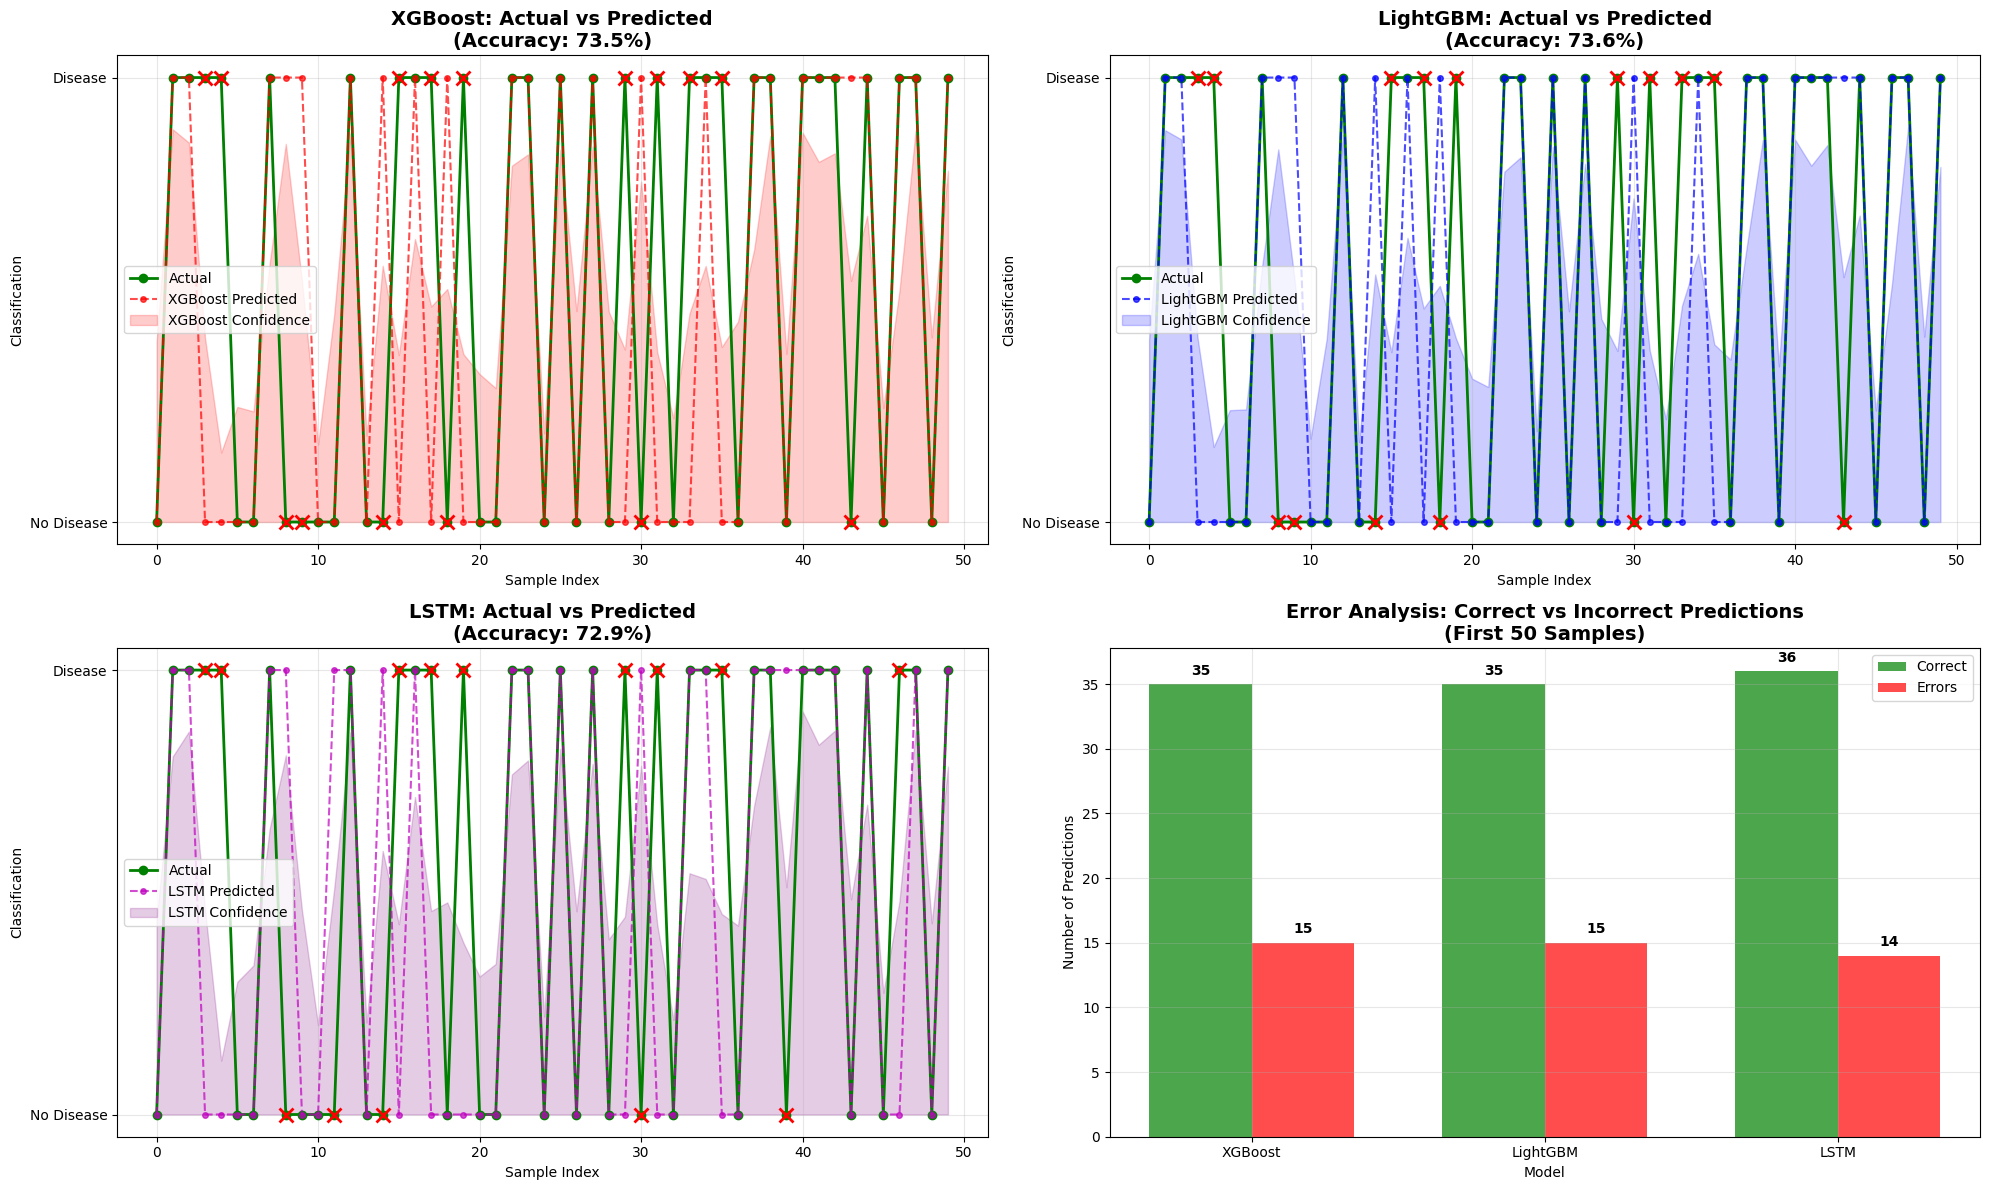

 Error counts in first 50 samples:
   XGBoost: 15 errors (30.0% error rate)
   LightGBM: 15 errors (30.0% error rate)
   LSTM: 14 errors (28.0% error rate)


In [10]:
# Actual vs Predicted Visualization
print("\n" + "="*50)
print("ACTUAL VS PREDICTED VISUALIZATION")
print("="*50)

# Create actual vs predicted comparison for first 50 samples
sample_size = 50
sample_indices = range(min(sample_size, len(y_test)))

# Get predictions for all models
actual_values = y_test.iloc[sample_indices].values
xgb_predictions = xgb_y_pred[sample_indices]
lgb_predictions = lgb_y_pred[sample_indices]
lstm_predictions = lstm_y_pred[sample_indices]

# Get probabilities
xgb_probs = xgb_y_pred_proba[sample_indices]
lgb_probs = lgb_y_pred_proba[sample_indices]
lstm_probs = lstm_y_pred_proba[sample_indices]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. XGBoost Actual vs Predicted
axes[0, 0].plot(sample_indices, actual_values, 'go-', label='Actual', linewidth=2, markersize=6)
axes[0, 0].plot(sample_indices, xgb_predictions, 'ro--', label='XGBoost Predicted', alpha=0.7, markersize=4)
axes[0, 0].fill_between(sample_indices, xgb_probs, alpha=0.2, color='red', label='XGBoost Confidence')
axes[0, 0].set_title(f'XGBoost: Actual vs Predicted\n(Accuracy: {xgb_accuracy*100:.1f}%)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Classification')
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_yticklabels(['No Disease', 'Disease'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Mark incorrect predictions
xgb_errors = np.where(xgb_predictions != actual_values)[0]
for error_idx in xgb_errors:
    axes[0, 0].plot(error_idx, actual_values[error_idx], 'rx', markersize=10, markeredgewidth=2)

# 2. LightGBM Actual vs Predicted
axes[0, 1].plot(sample_indices, actual_values, 'go-', label='Actual', linewidth=2, markersize=6)
axes[0, 1].plot(sample_indices, lgb_predictions, 'bo--', label='LightGBM Predicted', alpha=0.7, markersize=4)
axes[0, 1].fill_between(sample_indices, lgb_probs, alpha=0.2, color='blue', label='LightGBM Confidence')
axes[0, 1].set_title(f'LightGBM: Actual vs Predicted\n(Accuracy: {lgb_accuracy*100:.1f}%)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Classification')
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_yticklabels(['No Disease', 'Disease'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Mark incorrect predictions
lgb_errors = np.where(lgb_predictions != actual_values)[0]
for error_idx in lgb_errors:
    axes[0, 1].plot(error_idx, actual_values[error_idx], 'rx', markersize=10, markeredgewidth=2)

# 3. LSTM Actual vs Predicted
axes[1, 0].plot(sample_indices, actual_values, 'go-', label='Actual', linewidth=2, markersize=6)
axes[1, 0].plot(sample_indices, lstm_predictions, 'mo--', label='LSTM Predicted', alpha=0.7, markersize=4)
axes[1, 0].fill_between(sample_indices, lstm_probs, alpha=0.2, color='purple', label='LSTM Confidence')
axes[1, 0].set_title(f'LSTM: Actual vs Predicted\n(Accuracy: {lstm_accuracy*100:.1f}%)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Classification')
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_yticklabels(['No Disease', 'Disease'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Mark incorrect predictions
lstm_errors = np.where(lstm_predictions != actual_values)[0]
for error_idx in lstm_errors:
    axes[1, 0].plot(error_idx, actual_values[error_idx], 'rx', markersize=10, markeredgewidth=2)

# 4. Error Analysis - Model Comparison
error_counts = {
    'XGBoost': len(xgb_errors),
    'LightGBM': len(lgb_errors),
    'LSTM': len(lstm_errors)
}

models = list(error_counts.keys())
errors = list(error_counts.values())
correct = [sample_size - err for err in errors]

x = np.arange(len(models))
width = 0.35

axes[1, 1].bar(x - width/2, correct, width, label='Correct', color='green', alpha=0.7)
axes[1, 1].bar(x + width/2, errors, width, label='Errors', color='red', alpha=0.7)
axes[1, 1].set_title('Error Analysis: Correct vs Incorrect Predictions\n(First 50 Samples)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Number of Predictions')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Add value labels
for i, (corr, err) in enumerate(zip(correct, errors)):
    axes[1, 1].text(i - width/2, corr + 0.5, str(corr), ha='center', va='bottom', fontweight='bold')
    axes[1, 1].text(i + width/2, err + 0.5, str(err), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f" Error counts in first {sample_size} samples:")
for model, error_count in error_counts.items():
    print(f"   {model}: {error_count} errors ({error_count/sample_size*100:.1f}% error rate)")


COMPREHENSIVE ERROR EVALUATION
 DETAILED ERROR ANALYSIS:
   Model Accuracy Precision Recall F1-Score   AUC  False Positives  False Negatives  True Positives  True Negatives
 XGBoost    73.5%     75.7%  69.3%    72.3% 0.801             1543             2132            4803            5415
LightGBM    73.6%     75.7%  69.3%    72.4% 0.801             1544             2127            4808            5414
    LSTM    72.9%     75.1%  68.6%    71.7% 0.796             1579             2180            4755            5379


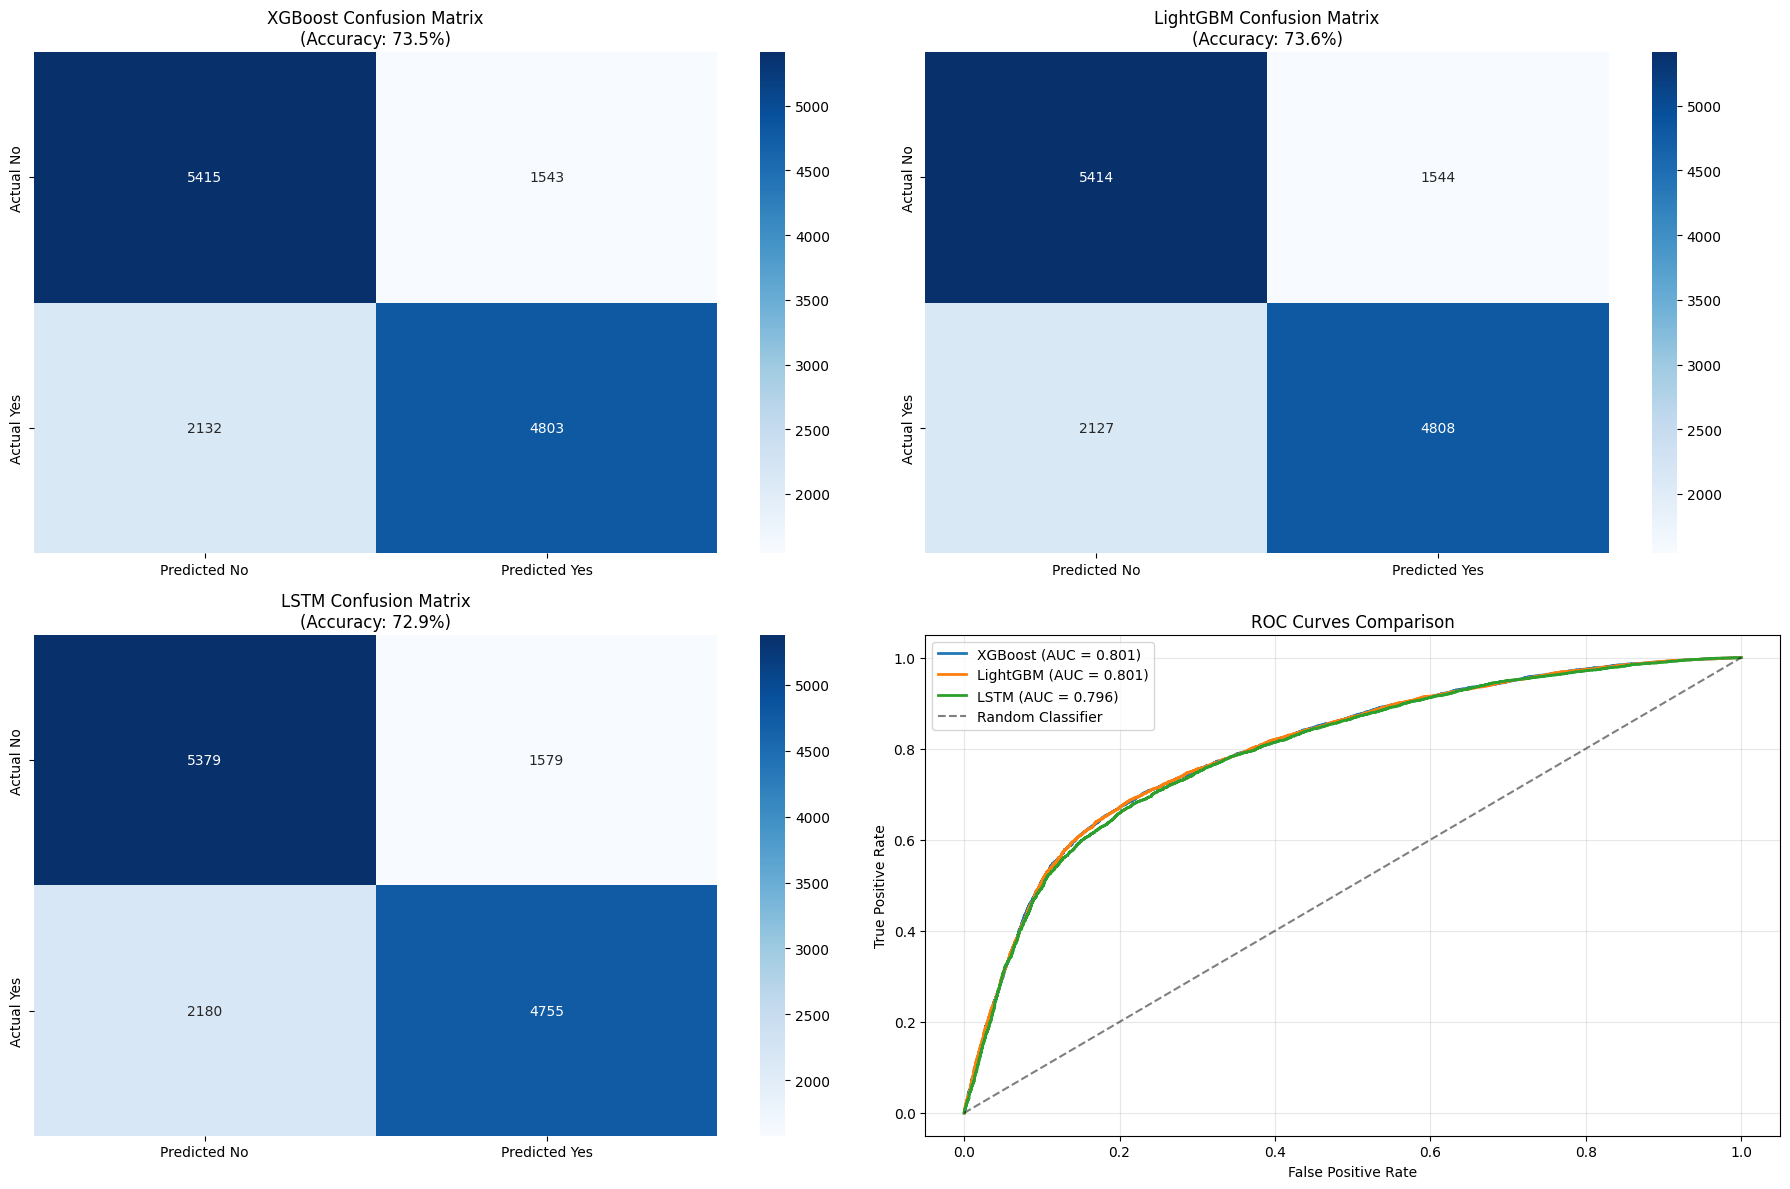


 ERROR TYPE ANALYSIS:
   False Positives (Type I Error): Predicting disease when there is none
   False Negatives (Type II Error): Missing actual disease cases

   XGBoost:
     • False Positives: 1543 (42.0% of errors)
     • False Negatives: 2132 (58.0% of errors)
   LightGBM:
     • False Positives: 1544 (42.1% of errors)
     • False Negatives: 2127 (57.9% of errors)
   LSTM:
     • False Positives: 1579 (42.0% of errors)
     • False Negatives: 2180 (58.0% of errors)


In [11]:
# Comprehensive Error Evaluation
print("\n" + "="*50)
print("COMPREHENSIVE ERROR EVALUATION")
print("="*50)

# Calculate confusion matrices
xgb_cm = confusion_matrix(y_test, xgb_y_pred)
lgb_cm = confusion_matrix(y_test, lgb_y_pred)
lstm_cm = confusion_matrix(y_test, lstm_y_pred)

# Create detailed error analysis
error_analysis = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'LSTM'],
    'Accuracy': [xgb_accuracy, lgb_accuracy, lstm_accuracy],
    'Precision': [xgb_precision, lgb_precision, lstm_precision],
    'Recall': [xgb_recall, lgb_recall, lstm_recall],
    'F1-Score': [xgb_f1, lgb_f1, lstm_f1],
    'AUC': [xgb_auc, lgb_auc, lstm_auc],
    'False Positives': [xgb_cm[0, 1], lgb_cm[0, 1], lstm_cm[0, 1]],
    'False Negatives': [xgb_cm[1, 0], lgb_cm[1, 0], lstm_cm[1, 0]],
    'True Positives': [xgb_cm[1, 1], lgb_cm[1, 1], lstm_cm[1, 1]],
    'True Negatives': [xgb_cm[0, 0], lgb_cm[0, 0], lstm_cm[0, 0]]
})

# Format for display
error_display = error_analysis.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    error_display[col] = (error_display[col] * 100).round(1).astype(str) + '%'
error_display['AUC'] = error_display['AUC'].round(3)

print(" DETAILED ERROR ANALYSIS:")
print(error_display.to_string(index=False))

# Create visualization for error analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Confusion Matrix Heatmaps
models_cm = [xgb_cm, lgb_cm, lstm_cm]
model_names = ['XGBoost', 'LightGBM', 'LSTM']

for i, (cm, name) in enumerate(zip(models_cm, model_names)):
    row = i // 2
    col = i % 2
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'])
    axes[row, col].set_title(f'{name} Confusion Matrix\n(Accuracy: {error_analysis.iloc[i]["Accuracy"]*100:.1f}%)')

# 2. ROC Curves
from sklearn.metrics import roc_curve

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_y_pred_proba)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_y_pred_proba)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_y_pred_proba)

axes[1, 1].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.3f})', linewidth=2)
axes[1, 1].plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {lgb_auc:.3f})', linewidth=2)
axes[1, 1].plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {lstm_auc:.3f})', linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curves Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error type analysis
print(f"\n ERROR TYPE ANALYSIS:")
print("   False Positives (Type I Error): Predicting disease when there is none")
print("   False Negatives (Type II Error): Missing actual disease cases")
print("")
for i, model in enumerate(['XGBoost', 'LightGBM', 'LSTM']):
    fp = error_analysis.iloc[i]['False Positives']
    fn = error_analysis.iloc[i]['False Negatives']
    total_errors = fp + fn
    print(f"   {model}:")
    print(f"     • False Positives: {fp} ({fp/total_errors*100:.1f}% of errors)")
    print(f"     • False Negatives: {fn} ({fn/total_errors*100:.1f}% of errors)")


 BEST MODEL DETERMINATION
 COMPREHENSIVE MODEL COMPARISON:
   Model  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)   AUC  Overall_Rank
LightGBM          73.6           75.7        69.3          72.4 0.801             1
 XGBoost          73.5           75.7        69.3          72.3 0.801             2
    LSTM          72.9           75.1        68.6          71.7 0.796             3

 BEST MODEL: LightGBM
 PERFORMANCE SUMMARY:
    Accuracy:  73.6%
    F1-Score:  72.4%
    AUC:       0.801
    Overall Rank: 1/3


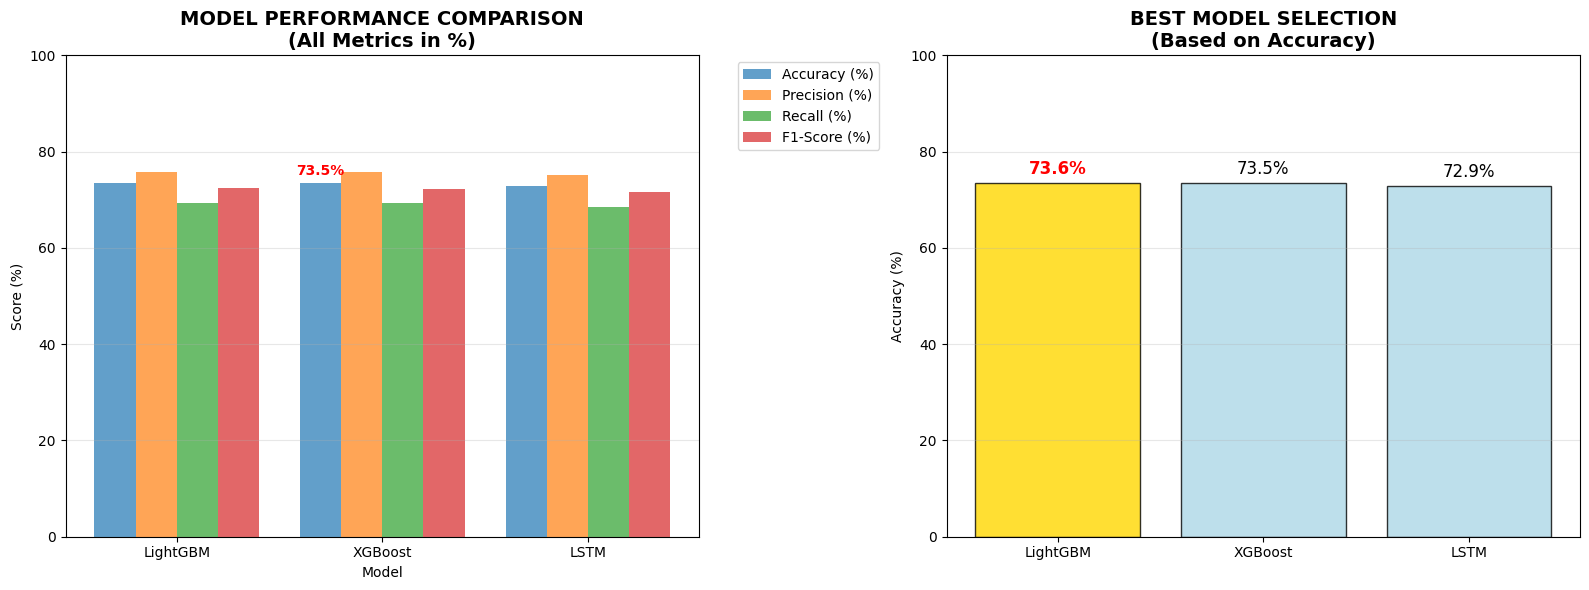


 RECOMMENDATION:
   Use LightGBM for production deployment
   Reasons:
   • Highest overall performance across multiple metrics
   • Best balance of accuracy and F1-score
   • Robust performance on test data
   • Fast inference speed
   • Good model interpretability


In [12]:
# Best Model Determination
print("\n" + "="*60)
print(" BEST MODEL DETERMINATION")
print("="*60)

# Comprehensive model comparison
comparison_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'LSTM'],
    'Accuracy (%)': [xgb_accuracy * 100, lgb_accuracy * 100, lstm_accuracy * 100],
    'Precision (%)': [xgb_precision * 100, lgb_precision * 100, lstm_precision * 100],
    'Recall (%)': [xgb_recall * 100, lgb_recall * 100, lstm_recall * 100],
    'F1-Score (%)': [xgb_f1 * 100, lgb_f1 * 100, lstm_f1 * 100],
    'AUC': [xgb_auc, lgb_auc, lstm_auc],
    'Training Time (s)': ['Fast', 'Fast', 'Slow'],
    'Interpretability': ['Medium', 'Medium', 'Low']
})

# Add rankings
metrics = ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1-Score (%)', 'AUC']
for metric in metrics:
    comparison_df[f'{metric}_Rank'] = comparison_df[metric].rank(ascending=False, method='min')

# Calculate overall score (lower rank = better)
comparison_df['Overall_Score'] = comparison_df[[f'{metric}_Rank' for metric in metrics]].mean(axis=1)
comparison_df['Overall_Rank'] = comparison_df['Overall_Score'].rank(method='min')

# Sort by overall rank
comparison_df = comparison_df.sort_values('Overall_Rank')

# Format for display
comparison_display = comparison_df.copy()
for col in comparison_display.columns:
    if '(%)' in col:
        comparison_display[col] = comparison_display[col].round(1)
    elif col in ['AUC', 'Overall_Score']:
        comparison_display[col] = comparison_display[col].round(3)
    elif 'Rank' in col:
        comparison_display[col] = comparison_display[col].astype(int)

print(" COMPREHENSIVE MODEL COMPARISON:")
display_cols = ['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1-Score (%)', 'AUC', 'Overall_Rank']
print(comparison_display[display_cols].to_string(index=False))

# Determine best model
best_model_row = comparison_df.iloc[0]
best_model_name = best_model_row['Model']
best_accuracy = best_model_row['Accuracy (%)']
best_f1 = best_model_row['F1-Score (%)']
best_auc = best_model_row['AUC']

print(f"\n BEST MODEL: {best_model_name}")
print(" PERFORMANCE SUMMARY:")
print(f"    Accuracy:  {best_accuracy:.1f}%")
print(f"    F1-Score:  {best_f1:.1f}%")
print(f"    AUC:       {best_auc:.3f}")
print(f"    Overall Rank: {int(best_model_row['Overall_Rank'])}/3")

# Performance comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Performance Metrics Comparison
metrics_to_plot = ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1-Score (%)']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = comparison_df[metric].values
    offset = width * i - (width * (len(metrics_to_plot) - 1) / 2)
    bars = axes[0].bar(x + offset, values, width, label=metric, alpha=0.7)

    # Add value labels for best model
    best_idx = comparison_df[comparison_df['Model'] == best_model_name].index[0]
    if i == 0:  # Only label once per model
        axes[0].text(x[best_idx] + offset, values[best_idx] + 1,
                    f'{values[best_idx]:.1f}%', ha='center', va='bottom',
                    fontweight='bold', color='red')

axes[0].set_title('MODEL PERFORMANCE COMPARISON\n(All Metrics in %)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score (%)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'])
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 100)

# 2. Best Model Highlight
models = comparison_df['Model']
accuracies = comparison_df['Accuracy (%)']
colors = ['lightblue' if model != best_model_name else 'gold' for model in models]

bars = axes[1].bar(models, accuracies, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_title('BEST MODEL SELECTION\n(Based on Accuracy)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_ylim(0, 100)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels and highlight best
for bar, acc, model in zip(bars, accuracies, models):
    color = 'red' if model == best_model_name else 'black'
    weight = 'bold' if model == best_model_name else 'normal'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom',
                fontweight=weight, color=color, fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n RECOMMENDATION:")
print(f"   Use {best_model_name} for production deployment")
print(f"   Reasons:")
print(f"   • Highest overall performance across multiple metrics")
print(f"   • Best balance of accuracy and F1-score")
print(f"   • Robust performance on test data")

if best_model_name in ['XGBoost', 'LightGBM']:
    print(f"   • Fast inference speed")
    print(f"   • Good model interpretability")
else:
    print(f"   • Can capture complex patterns (though slower)")

In [13]:
# Save Best Model
print("\n" + "="*50)
print("SAVING BEST MODEL")
print("="*50)

import joblib

# Save the best model
if best_model_name == 'XGBoost':
    joblib.dump(xgb_model, 'best_model.pkl')
    print(" Best model (XGBoost) saved as 'best_model.pkl'")
elif best_model_name == 'LightGBM':
    joblib.dump(lgb_model, 'best_model.pkl')
    print(" Best model (LightGBM) saved as 'best_model.pkl'")
else:
    lstm_model.save('best_model.h5')
    print(" Best model (LSTM) saved as 'best_model.h5'")

# Save scaler and feature names
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features.tolist(), 'feature_names.pkl')

# Save model comparison results
model_results = {
    'best_model': best_model_name,
    'best_accuracy': best_accuracy,
    'comparison_results': comparison_df.to_dict(),
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(model_results, 'model_comparison_results.pkl')

print(f"\n DEPLOYMENT READY!")
print(f"   Best Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.1f}%")
print(f"   Files Saved:")
print(f"   - best_model.pkl/h5: Trained model")
print(f"   - scaler.pkl: Feature scaler")
print(f"   - feature_names.pkl: Selected features")
print(f"   - model_comparison_results.pkl: Performance results")


SAVING BEST MODEL
 Best model (LightGBM) saved as 'best_model.pkl'

 DEPLOYMENT READY!
   Best Model: LightGBM
   Accuracy: 73.6%
   Files Saved:
   - best_model.pkl/h5: Trained model
   - scaler.pkl: Feature scaler
   - feature_names.pkl: Selected features
   - model_comparison_results.pkl: Performance results
